# Next Steps

### In the combine_merge_sets() method
1. Combine the words within columns to form lines, then save the modified line back to the text_df
2. Use the same process (.extract_words()) to pull data from tables, separate key-value pairs from other pairs, etc.


In [ ]:
%pip install pdfminer.six
%pip install pdfplumber
%pip install numpy pandas
%pip install textdistance
%pip install regex
%pip install strictyaml


In [9]:
%pip install pyyaml

   ---------------------------------------- 0.0/138.7 kB ? eta -:--:--
   -- ------------------------------------- 10.2/138.7 kB ? eta -:--:--
   ----------- --------------------------- 41.0/138.7 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 138.7/138.7 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure
# To extract text from tables in PDF
import pdfplumber
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional, Iterable, Dict, Tuple
import regex
from textdistance import hamming, jaro, levenshtein
import strictyaml 
import yaml
import itertools

In [2]:
from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

In [2]:
class pdf_data():
    def __init__(self, orig_filepath: str | Path, ocr_filepath: str | Path, config: str | Path) -> None:
        self.orig_filepath = orig_filepath
        self.ocr_filepath = ocr_filepath
        self.config = config  
        self.text_df = None  
        self.px_col_sep = 8
        self.px_word_sep = 2
        self.col_sep_str = ' | '

    def fill_implicit_keys(self, section_header, sep):
        section_dict = self.sections[section_header]
        for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():    
            mask = (self.text_df['norm_y_top'   ] > subsection_bounds['y_top'   ]) & \
                   (self.text_df['norm_y_bottom'] < subsection_bounds['y_bottom']) 
            subsect_df = self.text_df.loc[mask, :]

            if any(subsect_df['source'] == 'ocr'):
                page = pdfplumber.open(self.ocr_filepath ).pages[subsect_df.loc[subsect_df.index[0], 'page']]
            else:
                page = pdfplumber.open(self.orig_filepath).pages[subsect_df.loc[subsect_df.index[0], 'page']]
            
            words_df = self.get_words_df(page, subsect_df['y_top'].min(), subsect_df['y_bottom'].max())
    
            words_df.sort_values(by=['top', 'left'], ignore_index=True, inplace=True)

            split_lines = list()
            for text in subsect_df['text']:
                split_lines = split_lines + text.split(self.col_sep_str)
            for token in split_lines:
                if sep in token:
                    continue
                token_bounds = words_df.loc[words_df['text']==token, ['left', 'right']]
                mask = ((words_df['left' ] - token_bounds['left'].values > -2*self.px_col_sep) & \
                        (words_df['left' ] - token_bounds['left'].values <=  0                )) | \
                       ((words_df['right'] - token_bounds['right'].values < 2*self.px_col_sep) & \
                        (words_df['right'] - token_bounds['right'].values >= 0                ))
                same_column_tokens = words_df.loc[mask, 'text']
                
                implicit_key = [item.split(sep)[0] for item in same_column_tokens.values if len(item.split(sep)) == 2]
                if len(implicit_key) == 1:
                    tmp = []
                    #TODO Fill the implicit key in to the text in the correct spot. Then ready to extract the last bit of data, make comparisons between pdfs, and generate review files       

    def identify_line_merge_sets(self):
        merge_sets = list()
        for idx, line in self.text_df.iterrows():
            merge_set = np.where((self.text_df['norm_y_top']    < line['norm_y_bottom']) &
                                 (self.text_df['norm_y_top']    > line['norm_y_top']   )  )[0]
            merge_set = self.text_df.index[merge_set]
            if len(merge_set) > 0:
                merge_set = [idx] + merge_set.to_list()
                same_merge_set   = any([True if m_set == merge_set else False for m_set in merge_sets])
                overlapping_sets = [set_idx for set_idx, m_set in enumerate(merge_sets) if any(i for i in m_set if i in merge_set)]
                if same_merge_set:
                    continue
                elif len(overlapping_sets) == 1:
                    merge_sets[overlapping_sets[0]] = np.unique(merge_sets[overlapping_sets[0]] + merge_set).tolist() 
                elif len(overlapping_sets) > 1:
                    print('Have not written code to manage more than one overlapping set when combining lines')
                else:
                    merge_sets.append(merge_set)
        return merge_sets
    
    def get_words_df(self, page, y_top, y_bottom):
        page_crop = page.within_bbox((         0, y_top, 
                                        page.width, y_bottom))  

        words = page_crop.extract_words()  
        words_dict = dict(text=[], left=[], right=[], top=[], bottom=[])
        for word in words:
            if word['text'] == '|':
                continue
            word['text'] = word['text'].lower().replace('|','')
            for dict_key, word_key in zip(['text', 'left', 'right', 'top', 'bottom'],
                                            ['text',   'x0',    'x1', 'top', 'bottom']):
                words_dict[dict_key].append(word[word_key])
        
        words_df = pd.DataFrame.from_dict(words_dict)
        words_df.sort_values(by='left', ignore_index=True, inplace=True)

        return words_df

    def identify_columns_from_words_df(self, words_df):
        col_id = []
        col_num = 0
        prev_w_info = None
        for w_idx, w_info in words_df.iterrows():
            if prev_w_info is not None: 
                if (w_info['left'] - prev_w_info['right'] > self.px_col_sep):
                    col_num += 1
                elif (w_info['left'] - prev_w_info['right'] < 0):
                    w_info['right'] = prev_w_info['right'] 
            col_id.append(col_num)
            prev_w_info = w_info.copy()
        words_df['col_id'] = col_id
        words_df.sort_values(by=['col_id', 'top', 'left'], ignore_index=True, inplace=True)

        col_phrases = []
        for col_id in words_df['col_id'].unique():
            col_df = words_df.loc[words_df['col_id'] == col_id, :]
            col_phrases.append(' '.join(col_df['text']))

        return col_phrases 

    def organize_single_lines(self, merge_sets, ocr_pdf, orig_pdf):
        merge_list = list(itertools.chain.from_iterable(merge_sets))
        for idx, line in self.text_df.iterrows():
            if idx not in merge_list:   
                if line['source'] == 'ocr':
                    page = ocr_pdf.pages [line['page']]
                else:
                    page = orig_pdf.pages[line['page']]

                words_df = self.get_words_df(page, line['y_top'], line['y_bottom'])

                col_phrases = self.identify_columns_from_words_df(words_df)

                self.text_df.loc[idx, 'text'] = self.col_sep_str.join(col_phrases)

    def combine_merge_sets(self, merge_sets, ocr_pdf, orig_pdf):

        drop_idxs = list()
        for merge_set in merge_sets:
            partial_df = self.text_df.loc[merge_set, :]
            y_top    = partial_df['y_top'].min()    
            y_bottom = partial_df['y_bottom'].max()

            if any(partial_df['source'] == 'ocr'):
                page = ocr_pdf.pages [partial_df.loc[merge_set[0], 'page']]
            else:
                page = orig_pdf.pages[partial_df.loc[merge_set[0], 'page']]

            words_df = self.get_words_df(page, y_top, y_bottom)
            
            col_phrases = self.identify_columns_from_words_df(words_df)

            # replace first line in merge set with merged text and position info, then store indices of 
            # remaining merge set to drop at end of combine method
            self.text_df.loc[merge_set[0], 
                             ['text', 'y_bottom', 'x_left', 'x_right', 'norm_y_bottom',]] = [self.col_sep_str.join(col_phrases),
                                                                                             partial_df['y_bottom'].max(),
                                                                                             partial_df['x_left'].min(),
                                                                                             partial_df['x_right'].max(),
                                                                                             partial_df['norm_y_bottom'].max(),] 

            drop_idxs.extend(merge_set[1:])             

        self.text_df = self.text_df.drop(drop_idxs).reset_index(drop=True)

    def organize_text_lines_by_row_and_column(self):
        merge_sets = self.identify_line_merge_sets()
        ocr_pdf  = pdfplumber.open(self.ocr_filepath)
        orig_pdf = pdfplumber.open(self.orig_filepath) 
        self.organize_single_lines(merge_sets, ocr_pdf, orig_pdf)
        self.combine_merge_sets   (merge_sets, ocr_pdf, orig_pdf)
    
    def split_text_lines_with_pdfplumber(self, pdf, element, page_idx, text_dict,):
        did_split = False
        page = pdf.pages[page_idx]
        page_crop = page.within_bbox((         0, page.height - element.y1, 
                                      page.width, page.height - element.y0))  

        text = page_crop.extract_text_lines()
        
        if len(text) > 1:
            did_split = True
            for line in text:

                norm_y_top    = page_idx + (line['top'   ] / page.height)
                norm_y_bottom = page_idx + (line['bottom'] / page.height)
                if np.logical_not(np.any((np.isclose(self.text_df['norm_y_top'   ], norm_y_top   , atol=1e-2)) &
                                         (np.isclose(self.text_df['norm_y_bottom'], norm_y_bottom, atol=1e-2))  )):
                    text_dict['page'         ].append(page_idx)
                    text_dict['y_bottom'     ].append(line['bottom'])
                    text_dict['y_top'        ].append(line['top'])
                    text_dict['x_left'       ].append(line['x0'])
                    text_dict['x_right'      ].append(line['x1'])
                    text_dict['text'         ].append(line['text'].lower().replace('|', ''))
                    text_dict['norm_y_top'   ].append(norm_y_top)
                    text_dict['norm_y_bottom'].append(norm_y_bottom)
                    text_dict['source'       ].append('ocr')

                    print(f'\nstoring text from OCR on page {page_idx}:\n"{line['text'].lower()}"')

        return did_split    

    def get_text_lines_from_original(self):
        pdf = pdfplumber.open(self.orig_filepath)
        text_dict = dict(text=[], source=[], page=[], y_top=[], y_bottom=[], x_left=[], x_right=[], norm_y_top=[], norm_y_bottom=[],)
        for page_idx, page in enumerate(pdf.pages):
            text_lines = page.extract_text_lines()
            for line in text_lines:
                norm_y_top    = page_idx + (line['top'   ] / page.height)
                norm_y_bottom = page_idx + (line['bottom'] / page.height)

                text_dict['page'         ].append(page_idx)
                text_dict['y_bottom'     ].append(line['bottom'])
                text_dict['y_top'        ].append(line['top'])
                text_dict['x_left'       ].append(line['x0'])
                text_dict['x_right'      ].append(line['x1'])
                text_dict['text'         ].append(line['text'].lower().replace('|', ''))
                text_dict['norm_y_top'   ].append(norm_y_top)
                text_dict['norm_y_bottom'].append(norm_y_bottom)
                text_dict['source'       ].append('original')
        
        if self.text_df is None:
            self.text_df = pd.DataFrame(text_dict)
        else:
            tmp_text_df = pd.DataFrame(text_dict)
            self.text_df = pd.concat((self.text_df, tmp_text_df), axis=0, ignore_index=True)

        self.text_df.sort_values(by='norm_y_top', inplace=True, ignore_index=True, ascending=True)

    def get_text_lines_from_ocr(self, pages: Optional[Iterable[int]] = None) -> pd.DataFrame:
        text_dict = dict(text=[], source=[], page=[], y_top=[], y_bottom=[], x_left=[], x_right=[], norm_y_top=[], norm_y_bottom=[],)
        for page_idx, page in enumerate(extract_pages(self.ocr_filepath)):
            pdf = pdfplumber.open(self.ocr_filepath)
            for el_idx, element in enumerate(page):
                if isinstance(element, LTTextContainer):
                    did_split = self.split_text_lines_with_pdfplumber(pdf, element, page_idx, text_dict)
                    if not did_split:
                        y_top = page.height - element.y1
                        y_bottom = page.height - element.y0 
                        norm_y_top    = page_idx + y_top    / page.height
                        norm_y_bottom = page_idx + y_bottom / page.height
                        if np.logical_not(np.any((np.isclose(self.text_df['norm_y_top'   ], norm_y_top   , atol=1e-2)) &
                                                 (np.isclose(self.text_df['norm_y_bottom'], norm_y_bottom, atol=1e-2))  )):
                            text_dict['page'         ].append(page_idx)
                            text_dict['y_bottom'     ].append(y_bottom)
                            text_dict['y_top'        ].append(y_top)
                            text_dict['x_left'       ].append(element.x0)
                            text_dict['x_right'      ].append(element.x1)
                            text_dict['text'         ].append(element.get_text().lower().replace('\n', '').replace('|', ''))
                            text_dict['norm_y_top'   ].append(norm_y_top)
                            text_dict['norm_y_bottom'].append(norm_y_bottom)
                            text_dict['source'       ].append('ocr')
    
                            print(f'\nstoring text from OCR on page {page_idx}:\n"{element.get_text().lower().replace('\n', '')}"')

                elif isinstance(element, LTRect):
                    print(f'page = {page_idx}, ypos={element.y0}, type={type(element)}')
                else:
                    print(f'page = {page_idx}, ypos={element.y0}, type={type(element)}')

        if self.text_df is None:
            self.text_df = pd.DataFrame(text_dict)
        elif len(text_dict['text']) > 0:
            tmp_text_df  = pd.DataFrame(text_dict)
            self.text_df = pd.concat((self.text_df, tmp_text_df), axis=0, ignore_index=True)

        self.text_df.sort_values(by='norm_y_top', inplace=True, ignore_index=True, ascending=True)

    def get_section_headers(self):
        with open(self.config, 'r') as file:
            self.config_data = yaml.safe_load(file) 
        
        self.sections = dict()
        for section in self.config_data['sections']:
            self.sections[section['header']] = dict(bounds = pd.DataFrame(),
                                                    extract = section['extract'])

    def get_section_bounds(self):

        self.get_section_headers()

        # detect start and end of sections
        prev_section_info = dict(header=None, df_row=None)
        prev_page = 0
        for row_idx, text_data in self.text_df.iterrows():
            detected_section = None
            for header in self.sections.keys():
                match = regex.search(f'{header}{{s<=3,i<=3,d<=3}}', text_data['text'], regex.BESTMATCH)    
                if match is not None:
                    detected_section = header
                    break

            if text_data['page'] > prev_page or detected_section is not None:
                if prev_section_info['header'] is not None:   # store end of sections
                    prev_df_idx = self.sections[prev_section_info['header']]['bounds'].index[-1] 
                    prev_bottom = prev_page+0.9999 if (text_data['page'] > prev_page) else text_data['norm_y_top'] 
                    self.sections[prev_section_info['header']]['bounds'].loc[prev_df_idx, ['y_bottom',]] = [prev_bottom]
                # store start of sections
                top = text_data['page'] if (text_data['page'] > prev_page) else text_data['norm_y_top']
                tmp_df = pd.DataFrame(data    = zip([top], [np.nan], [False]),
                                      columns = ['y_top', 'y_bottom', 'data_extracted'],)
                header = detected_section
                self.sections[header]['bounds'] = pd.concat((self.sections[header]['bounds'], tmp_df), ignore_index=True)
                prev_section_info['header'] = header
                if text_data['page'] > prev_page:
                    prev_page+=1
            prev_section_info['df_row'] = row_idx
        
        # store end of final section
        prev_y_bottom = self.text_df.loc[prev_section_info['df_row'], 'norm_y_bottom']
        prev_df_idx = self.sections[prev_section_info['header']]['bounds'].index[-1] 
        self.sections[prev_section_info['header']]['bounds'].loc[prev_df_idx, ['y_bottom',]] = [np.ceil(prev_y_bottom),]
    
    def extract_table(self, subsection_bounds):  
        page_num = int(np.floor(subsection_bounds['y_top'])) 
        pdf = pdfplumber.open(self.orig_filepath)
        table_page = pdf.pages[page_num]
        table_crop = table_page.within_bbox((               0, (subsection_bounds['y_top'   ]-page_num)*table_page.height, 
                                             table_page.width, (subsection_bounds['y_bottom']-page_num)*table_page.height))
        table = table_crop.extract_table()
        # print((subsection_bounds['y_top'   ]-page_num)*table_page.height, (subsection_bounds['y_bottom']-page_num)*table_page.height, table)
        return table
    
    def extract_text_lines_from_original(self, subsection_bounds):
        page_num = int(np.floor(subsection_bounds['y_top'])) 
        pdf = pdfplumber.open(self.orig_filepath)
        page = pdf.pages[page_num]
        page_crop = page.within_bbox((         0, (subsection_bounds['y_top'   ]-page_num)*page.height, 
                                      page.width, (subsection_bounds['y_bottom']-page_num)*page.height))  

        text = page_crop.extract_text_lines()

        for line in text:
            line['norm_y_top']    = page_num + (line['top']    / page.height)
            line['norm_y_bottom'] = page_num + (line['bottom'] / page.height)
            line['page']          = page_num
            line['y_bottom']      = page.height - line['bottom']
            line['y_top']         = page.height - line['top']
            line['text'] = line['text'].lower().replace('|', '')

        return text  

    def table_to_df(self, 
                    table: List[List[str]], 
                    extract_params: str | Dict | List[Dict],
                    ) -> pd.DataFrame:
        if type(extract_params) == str and 'col' in extract_params.lower():
            info_keys = list()
            data = list()
            for row in table:
                iKey = row.pop(0)
                info_keys.append(iKey)
                data.append(row)
            df = pd.DataFrame(data=np.array(data).transpose(), columns=info_keys)

        elif type(extract_params) == str and 'row' in extract_params.lower():
            info_keys = table[0]
            data = table[1:]
            df = pd.DataFrame(data=data, columns=info_keys)

        else:
            print('There is no method implemented for converting data with this extraction method to a DataFrame')
            df = None
        
        return df 
 
    def extract_table_data(self):
        for section_header, section_dict in self.sections.items():
            for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():
                if subsection_bounds['data_extracted']:
                    continue

                table = self.extract_table(subsection_bounds)
                if table is not None:
                    data_df = self.table_to_df(table, section_dict['extract'])
                    data_df = data_df.loc[:, [col for col in data_df.columns if col.lower() != section_header]]
                    if 'data' in section_dict.keys(): 
                        section_dict['data'] = pd.concat((section_dict['data'], data_df),
                                                         axis=0,
                                                         ignore_index=True)
                    else:
                        section_dict['data'] = data_df
                    
                    section_dict['bounds'].loc[sub_idx, 'data_extracted'] = True

    def align_data_to_existing_df(self,
                                  section_dict: Dict,
                                  subsect_df: pd.DataFrame,
                                 ):
        if type(section_dict['extract']) == str and 'col' in section_dict['extract'].lower():
            info_keys_to_match = list(section_dict['data'].columns)
            original_info_keys = list(section_dict['data'].columns)
            info_keys = list()
            data      = list()
            for text in subsect_df['text']:
                row = text.split(self.col_sep_str)
                iKey = row.pop(0)
                match_score = np.array([levenshtein.normalized_similarity(iKey, matchKey) for matchKey in info_keys_to_match])
                try:
                    matched_key = info_keys_to_match.pop(np.where(match_score == match_score.max())[0][0])
                    info_keys.append(matched_key)
                    data.append(row)
                except:
                    print(f'\nNo matched key: iKey={iKey}, text={text}')
            
            # Add dummy data for unmatched keys
            for key in info_keys_to_match:
                info_keys.append(key)
                data.append(['data_not_found' for k in range(expected_num_items)])

            expected_num_items = pd.Series([len(d) for d in data]).mode()[0]
            wrong_count_info = [(idx, len(d)) for idx, d in enumerate(data) if len(d) != expected_num_items]
            for idx, num_items in wrong_count_info:
                data[idx] = ['wrong_num_columns' for k in range(expected_num_items)]
                print(f'\n"{info_keys[idx]}" contained the wrong number of columns in the line.')

            correct_order = [np.where(np.array(original_info_keys) == key)[0][0] for key in info_keys]
            _, info_keys = zip(*sorted(zip(correct_order, info_keys)))
            _, data      = zip(*sorted(zip(correct_order, data))) 

            data_df = pd.DataFrame(data=np.array(data).transpose(), columns=info_keys)
            section_dict['data'] = pd.concat((section_dict['data'], data_df),
                                              axis=0,
                                              ignore_index=True)
        return

    def get_multilevel_key_value_pairs(self, section_dict, items, sep, page):
        filling_subheader = False
        for item in items: 
            split_item = item.split(sep)
            if len(split_item) == 2:
                key, value = split_item
                value = value[1:]  if value[0]  == ' '  else value
                value = value[:-1] if value[-1] == '\n' else value
                if filling_subheader:
                    section_dict['data'][stored_key][key] = value
                    print(f'{stored_key} - {key}{sep} {value}')
                else:
                    section_dict['data'][key] = value     
                    print(f'{key}{sep} {value}')
            elif len(split_item) == 1:

                row_crop = page.within_bbox((            0, y_top, 
                                            page.width, y_bottom))  

                words = page_crop.extract_words()  

                stored_key = split_item
                section_dict['data'][stored_key] = dict()
                filling_subheader = True
            
                
                     


    def extract_key_value_pairs(self, 
                                section_dict: Dict, 
                                subsect_df: pd.DataFrame, 
                                sep: str = ':',
                                ) -> Dict:
        
        section_dict['data'] = dict()
        for l_idx, line in subsect_df.iterrows(): 
            items = line['text'].split(self.col_sep_str)
            key_value_pairs = [item for item in items if len(item.split(sep)) == 2]
            if len(key_value_pairs) == len(items):
                for item in key_value_pairs:
                    key, value = item
                    value = value[1:]  if value[0]  == ' '  else value
                    value = value[:-1] if value[-1] == '\n' else value
                    section_dict['data'][key] = value     
                    print(f'{key}{sep} {value}') 

            else:
                if line['source'] == 'original':
                    pdf = pdfplumber.open(self.orig_filepath)
                elif line['source'] == 'ocr':
                    pdf = pdfplumber.open(self.ocr_filepath)
                self.get_multilevel_key_value_pairs(section_dict, items, sep, pdf[line['page']])

        # for l_idx, line in subsect_df.iterrows(): 
        #     parsed_line = line['text'].split(sep)
        #     if len(parsed_line) == 2: 
        #         key, value = parsed_line
        #         value = value[1:]  if value[0]  == ' '  else value
        #         value = value[:-1] if value[-1] == '\n' else value
        #         section_dict['data'][key] = value     
        #         print(f'{key}{sep} {value}')   
        #     elif len(parsed_line) > 2:
        #         new_sep = ' '
        #         new_split_line = line['text'].split(new_sep)
        #         key_end_idxs = [idx   for idx, token in enumerate(new_split_line) if token[-1] == sep]
        #         val_idxs     = [idx+1 for idx in key_end_idxs]
        #         values       = [val   for idx, val in enumerate(new_split_line) if idx in val_idxs]
        #         values       = [val[:-1] if val[-1] == '\n' else val for val in values] 
                
        #         key_start_idxs = [0] + [idx+1 for idx in val_idxs]
        #         keys = list()
        #         for start, end in zip(key_start_idxs, key_end_idxs):
        #             key = new_sep.join([token for idx, token in enumerate(new_split_line) if idx >= start and idx <= end])
        #             keys.append(key)
        #         keys = [key.replace(sep, '') for key in keys]
                
        #         for key, value in zip(keys, values):
        #             section_dict['data'][key] = value 

    def extract_text_data(self):
        for section_header, section_dict in self.sections.items():
            for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():
                if subsection_bounds['data_extracted']:
                    continue

                mask = (self.text_df['norm_y_top'   ] > subsection_bounds['y_top'   ]) & \
                       (self.text_df['norm_y_bottom'] < subsection_bounds['y_bottom']) 
                subsect_df = self.text_df.loc[mask, :]
                
                if 'data' in section_dict.keys() and type(section_dict['data']) == pd.DataFrame:
                    self.align_data_to_existing_df(section_dict, subsect_df)
                else:
                    self.extract_key_value_pairs(section_dict, subsect_df, sep=':')
                
                section_dict['bounds'].loc[sub_idx, 'data_extracted'] = True

    def print_text(self):
        max_x = 0
        for page_text in self.text_containers:
            for text_container in page_text:
                if text_container.x1 > max_x:
                    max_x = text_container.x1
        for page_num, page_text in enumerate(self.text_containers):
            print('###############################################')
            print(f'Page {page_num}')
            print('###############################################') 
            for text_container in page_text:  
                text = text_container.get_text()
                # print(f'{text_container.y0} to {text_container.y1}', text)
                print(text_container.y1, text_container.y0, text)


class exhibit_data(pdf_data):
    def __init__(self, orig_filepath: str | Path, ocr_filepath: str | Path,  config: str | Path) -> None:
        super().__init__(orig_filepath, ocr_filepath, config)

    def align_line_configuration_data(self): # TODO
        tmp = []
    
    def get_exhibit_name(self):
        for text_container in self.text_containers[0]:
            text = text_container.get_text()
            if 'exhibit' in text.lower():
                pattern = regex.compile(r'^\s+')
                exhibit = pattern.sub('', text.lower().replace('exhibit', '').replace('\n', ''))
                self.exhibit = exhibit
    
    def get_ground_space_requirements(self, keyphrases: List[str]):
        for page_text in self.text_containers:
            examine_text  = False
            get_next_line = True
            line_iter = iter(page_text)
            while get_next_line:
                text_container = line_iter.__next__()
                text = text_container.get_text().lower()
                if examine_text:
                    split_text = text.split(' ')
                    if any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                            or hamming.normalized_similarity(t, 'specifications') > 0.75
                            for t in split_text]):
                        get_next_line = False
                    else:
                        for key in keyphrases:
                            pattern = fr'((?<={key})\w+)'
                            value = regex.findall(f'{pattern}{{e<=3}}', text, regex.BESTMATCH)
                            print(value)
                # elif any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                #           or hamming.normalized_similarity(t, 'specifications') > 0.75
                #             for t in split_text])::

# fuzzy_pattern = f'({pattern}){{e<=3}}'
# text = 'I went to the doctor on 7022-O3-I6.'

# match = regex.search(fuzzy_pattern, text, regex.BESTMATCH)
# match.groupdict()

                else:
                    if hamming.normalized_similarity(text.lower(), 'ground space requirements') > 0.75:
                        examine_text = True
    
    def get_equipment_specifications(self):
        for page_text in self.text_containers:
            examine_text  = False
            get_next_line = True
            line_iter = iter(page_text)
            while get_next_line:
                text_container = line_iter.__next__()
                text = text_container.get_text().lower()
                if examine_text:
                    split_text = text.split(' ')
                    if any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                            or hamming.normalized_similarity(t, 'specifications') > 0.75
                            for t in split_text]):
                        get_next_line = False

                
                

In [3]:
new_ocr_pdf_path  = Path('amendments/New_Exhibit_Redacted_OCR_new.pdf')
new_orig_pdf_path = Path('amendments/New_Exhibit_Redacted.pdf')
old_ocr_pdf_path  = Path('amendments/Old_Exhibit_Redacted_OCR_new.pdf')
old_orig_pdf_path = Path('amendments/Old_Exhibit_Redacted.pdf')

config_path = Path(r'C:\Users\Dalton\Documents\personal_records\apex_consulting\materials_and_amendments_OCR\configs\atc_extra_info_config.yaml')


In [ ]:
new_exhibit = exhibit_data(new_orig_pdf_path, new_ocr_pdf_path, config_path)
new_exhibit.get_text_lines_from_original()
new_exhibit.get_text_lines_from_ocr()
new_exhibit.organize_text_lines_by_row_and_column()
new_exhibit.get_section_bounds()
new_exhibit.extract_table_data()
new_exhibit.extract_text_data()

In [ ]:
for line, data in new_exhibit.text_df.iterrows():
    print(data.text)

In [ ]:
new_exhibit.extract_text_data()

In [ ]:
new_exhibit.sections['ground space requirements']['data']
new_exhibit.sections['backup power requirements']['data']
new_exhibit.sections['utility requirements']['data']
new_exhibit.sections['transmitter & receiver specifications']['data']
new_exhibit.sections['equipment specifications']['data']

In [4]:
old_exhibit = exhibit_data(old_orig_pdf_path, old_ocr_pdf_path, config_path)
old_exhibit.get_text_lines_from_original()
old_exhibit.get_text_lines_from_ocr()
old_exhibit.organize_text_lines_by_row_and_column()
old_exhibit.get_section_bounds()



storing text from OCR on page 0:
"exhibit a-3"

storing text from OCR on page 0:
"total lease area sq.ft:21600° primary contiguous lease area l:1200° w:1800 h:1000 sq.ft: 216.00)"

storing text from OCR on page 0:
"ground space requirements"

storing text from OCR on page 0:
"concrete pad 1000 16.00" nia 160.00]"

storing text from OCR on page 0:
"outside primary lease area nia nia nia sq. ft: n/a|"

storing text from OCR on page 0:
"backup power requirements"

storing text from OCR on page 0:
"generator: nia capacity(kw): n/a fuel tank size(gal): n/a fuel type: nia fuel tank setback{radiu:"

storing text from OCR on page 0:
"utility requirements"

storing text from OCR on page 0:
"power provided by: utiity company direct"

storing text from OCR on page 0:
"telco/lnterconnect:"

storing text from OCR on page 0:
"ua"

storing text from OCR on page 0:
"transmitter & receiver specifications"

storing text from OCR on page 0:
"type: n/a quantity: nia tx power(watts): nia erp(watts): n/a"


In [5]:
old_exhibit.fill_implicit_keys('ground space requirements', ':')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
old_exhibit.extract_table_data()



In [290]:
old_exhibit.extract_text_data()


outside primary lease area | nia | nia | nia | sq. ft: n/a
power provided by: utiity company direct
telco/lnterconnect: ua
telco/lnterconnect: ua

"Line Quant. Per
Azimuth/Sector" contained the wrong number of columns in the line.

"Quant. Per
Azimuth/Sector" contained the wrong number of columns in the line.


In [287]:
old_exhibit.sections['equipment specifications']['data']

,,Type,Manufacturer,Model #,Dimensions HxWxD,Weight(lbs.),Location,RAD Center AGL,Equipment Tip\nHeight,Equipment Base\nHeight,...,TX/RX Frequency\nUnits,TX Frequency,RX Frequency,Using Unlicensed\nFrequencies?,Equipment Gain,Total # of Lines,Line Quant. Per\nAzimuth/Sector,Line Type,Line Diameter Size,Line Configuration
0,None,DISH-HP,RFS,SB6-W60BC,6.23' x 6.23' x 2.98',198.0,Tower,155.0',158.1',151.9',...,MHz,6400,6400,No,35.7/ 36.7/ 37.3,1,1,Coax,"0.29"" (7.2mm) RG-8",N/A
1,None,DISH-HP,Commscope,USX10-11W,10.00' x -' x -',579.8,Tower,155.0',160.0',150.0',...,GHz,11,1,No,N/A,0,N/A,N/A,N/A,N/A
2,None,Radio/ODU,Ceragon,RFU-D,"9.1"" x 9.2"" x 3.9""",14.3,Tower,155.0',155.4',154.6',...,N/A,N/A,N/A,No,N/A,4,See Config. Summary,Multiple,See Config. Summary,"2 - Control Cable;\n0.31"" (7.8mm) Cable;\n2\n2..."
3,None,Radio/ODU,Ceragon,FibeAir IP-20E,"9.2"" x 9.1"" x 3.9""",14.3,Tower,155.0',155.4',154.6',...,N/A,N/A,N/A,No,N/A,0,N/A,N/A,N/A,N/A
4,None,DISH-HP,RFS,SB4-W60,4.14' x 4.14' x -',77.0,Tower,125.0',127.1',122.9',...,MHz,6400,6400,No,32.4 / 32.7 / 33.4,1,1,Coax,"0.29"" (7.2mm) RG-8",N/A
5,None,Radio/ODU,Ceragon,FibeAir IP-20E,"9.2"" x 9.1"" x 3.9""",14.3,Tower,125.0',125.4',124.6',...,N/A,N/A,N/A,No,N/A,0,N/A,N/A,N/A,N/A
6,na,panel,cellmax,cmabigs21/e06,81.1'x7.7'x48,350,"tower,","180.0""",na,1766,...,mhz,1930-1945.2145- 215517351740,"11875505-12816355,21174450-",no,1834,6,wrong_num_columns,na,18.31 18.7/192,coax
7,na,panel,rfs,apxvaa24_43-u-a20|,96'x24'x85,1014,"tower,","180.0""",111,1760°,...,mhz,668-638,622642,no,1840,3,wrong_num_columns,nn,132/136,coax
8,na,tta,rfs,atm1900d-1cwa,86x10x26,84,tower,180.0,nn,1796,...,na,nia,na,no,1804°,1,wrong_num_columns,11000,2,fiberfhybrid
9,na,rrurrh,ericsson,rruz2,"202x132 x69""",529,tower,"180.0""",1,1792,...,mhz,"21452155, 1736 1740",74512715450 2135,no,1808,2,wrong_num_columns,2,na,‘conduit


In [213]:
for text in old_exhibit.text_df['text']:
    print(text)

exhibit a-3
ground space requirements
total lease area sq.ft:21600° primary contiguous lease area l:1200° w:1800 h:1000 sq.ft: 216.00)
concrete pad 1000 16.00" nia 160.00]
outside primary lease area nia nia nia sq. ft: n/a|
backup power requirements
generator: nia capacity(kw): n/a fuel tank size(gal): n/a fuel type: nia fuel tank setback{radiu:
utility requirements
power provided by: utiity company direct
ua
telco/lnterconnect:
transmitter & receiver specifications
type: n/a quantity: nia tx power(watts): nia erp(watts): n/a
equipment specifications
type panel panel tta rrurrh rrurrh rrurrh
manufacturer cellmax rfs rfs ericsson ericsson ericsson
model # cmabigs21/e06 | apxvaa24_43-u-a20| atm1900d-1cwa rruz2 rru22 radio 4478 b71
dimensions hxwxd | 81.1'x7.7'x48 | 96'x24'x85 | 86x10x26 | 202x132 x69" | 02x 132x689" | 16x 132 x74"
[weight(ibs.) 350 1014 84 529 529 600
location tower, tower, tower tower tower tower
rad center agl 180.0" 180.0" 180.0 180.0" 180.0" 180.0
equipment tip 1834 

In [129]:
old_exhibit.sections['equipment specifications']['data'].columns

Index(['', 'Type', 'Manufacturer', 'Model #', 'Dimensions HxWxD',
       'Weight(lbs.)', 'Location', 'RAD Center AGL', 'Equipment Tip\nHeight',
       'Equipment Base\nHeight', 'Mount Type', 'Quantity',
       'Azimuths/Dir. of\nRadiation', 'Quant. Per\nAzimuth/Sector',
       'TX/RX Frequency\nUnits', 'TX Frequency', 'RX Frequency',
       'Using Unlicensed\nFrequencies?', 'Equipment Gain', 'Total # of Lines',
       'Line Quant. Per\nAzimuth/Sector', 'Line Type', 'Line Diameter Size',
       'Line Configuration'],
      dtype='object')

In [59]:
new_exhibit.sections['equipment specifications']['data'].columns

Index(['Type', 'Manufacturer', 'Model #', 'Dimensions\nHxWxD', 'Weight (lbs.)',
       'Location', 'RAD Center AGL', 'Tip Height', 'Base Height', 'Mount Type',
       'Quantity', 'Azimuths/Dir. of\nRadiation', 'Quant. Per\nAzimuth/Sector',
       'TX/RX Frequency\nUnits', 'TX Frequency', 'RX Frequency',
       'Using Unlicensed\nFrequencies?', 'Antenna Gain', 'Total # of Lines',
       'Individual Line\nConfiguration', 'Conduit\nConfiguration'],
      dtype='object')

In [73]:
[(row.norm_y_top, row.norm_y_bottom ,row.text) for idx, row in old_exhibit.text_df.iterrows() if 'type' in row.text]

[(0.21022727272727273,
  0.21654040404040403,
  'generator: nia capacity(kw): n/a fuel tank size(gal): n/a fuel type: nia fuel tank setback{radiu:'),
 (0.3055555555555556,
  0.31186868686868685,
  'type: n/a quantity: nia tx power(watts): nia erp(watts): n/a'),
 (0.336489898989899,
  0.38762626262626265,
  'type panel panel tta rrurrh rrurrh rrurrhmanufacturer cellmax rfs rfs ericsson ericsson ericssonmodel # cmabigs21/e06 | apxvaa24_43-u-a20| atm1900d-1cwa rruz2 rru22 radio 4478 b71'),
 (0.514520202020202,
  0.5473484848484849,
  'mount type side am side am side am side am side am side amquantity 6 3 3 1 2 3'),
 (0.7329545454545454,
  0.7670454545454546,
  'fine quant per na nn 11000 2 n nnline type coax coax fiberfhybrid ‘conduit hard line coax'),
 (1.0802272727272726,
  1.0863636363636364,
  'type dish-hp dish-hp radio/odu radio/odu dish-hp radio/odu'),
 (1.2581818181818183,
  1.264318181818182,
  'mount type pole mount pole mount pole mount pole mount pole mount pole mount'),
 (1.4

In [62]:
page_num = 0

# Open the pdf file
pdf = pdfplumber.open(new_exhibit.orig_filepath)
# Find the examined page
table_page = pdf.pages[page_num]
table_page.to_image()
for line in table_page.extract_text_lines():
    print(line['text'].lower())

exhibit a-4
ground space requirements
total lease area sq.ft: 216.00 primary contiguous lease area l: 12.00' w: 18.00' h: 10.00' sq.ft: 216.00
concrete pad 10.00' 16.00' n/a 160.00
outside primary lease area n/a n/a n/a sq.ft: n/a
backup power requirements
generator: n/a fuel tank size (gal): n/a fuel type: n/a fuel tank setback (radius): n/a
utility requirements
power provided by: utility company direct
telco/interconnect: n/a
transmitter & receiver specifications
type: n/a quantity: n/a tx power (watts): n/a erp power (watts): n/a
equipment specifications
type gps panel panel tta rru/rrh rru/rrh
manufacturer generic rfs cellmax rfs ericsson ericsson
apxvaa24_43-u-
model # gps cma-b/6521/e0-6 atm1900d-1cwa radio 4478 b71 rru22
a20
dimensions
12" x 9" x 6" 96" x 24" x 8.5" 81.1" x 7.7" x 4.8" 8.6" x 10" x 2.6" 15" x 13.2" x 7.4" 20.2" x 13.2" x 6.9"
hxwxd
weight (lbs.) 10.0 101.4 35.0 8.4 60.0 52.9
location ground tower tower tower tower tower
rad center agl n/a 180.0' 180.0' 180.0' 18

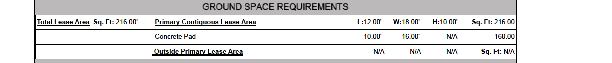

In [86]:
# table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
table_crop = table_page.within_bbox((0, .11*table_page.height, table_page.width, .19*table_page.height))
tmp = table_crop.to_image()
tmp
# Extract the appropriate table
# tmp = []

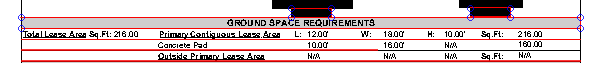

In [34]:
table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "lines",
    "snap_y_tolerance": 5,
    "intersection_x_tolerance": 5,
}
tmp.reset().debug_tablefinder(table_settings)

In [29]:
table = table_crop.extract_tables(table_settings)
text = table_crop.extract_text_lines()
text[3]

NameError: name 'table_crop' is not defined

In [99]:
pdf = pdfplumber.open(old_exhibit.orig_filepath)
table_page = pdf.pages[1]
text = table_page.extract_text_lines()
for line in text:
    print(line['text'])


Type DISH-HP DISH-HP Radio/ODU Radio/ODU DISH-HP Radio/ODU
Manufacturer RFS Commscope Ceragon Ceragon RFS Ceragon
Model # SB6-W60BC USX10-11W RFU-D FibeAir IP-20E SB4-W60 FibeAir IP-20E
Dimensions HxWxD 6.23' x 6.23' x 2.98' 10.00' x -' x -' 9.1" x 9.2" x 3.9" 9.2" x 9.1" x 3.9" 4.14' x 4.14' x -' 9.2" x 9.1" x 3.9"
Weight(lbs.) 198.0 579.8 14.3 14.3 77.0 14.3
Location Tower Tower Tower Tower Tower Tower
RAD Center AGL 155.0' 155.0' 155.0' 155.0' 125.0' 125.0'
Equipment Tip
158.1' 160.0' 155.4' 155.4' 127.1' 125.4'
Height
Equipment Base
151.9' 150.0' 154.6' 154.6' 122.9' 124.6'
Height
Mount Type Pole Mount Pole Mount Pole Mount Pole Mount Pole Mount Pole Mount
Quantity 1 1 2 1 1 1
Azimuths/Dir. of
292.15 184.14 184.14 292.15 292.15 292.15
Radiation
Quant. Per
1 1 2 1 1 1
Azimuth/Sector
TX/RX Frequency
MHz GHz N/A N/A MHz N/A
Units
TX Frequency 6400 11 N/A N/A 6400 N/A
RX Frequency 6400 1 N/A N/A 6400 N/A
Using Unlicensed
No No No No No No
Frequencies?
Equipment Gain 35.7/ 36.7/ 37.3 N/

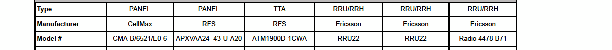

In [81]:
pdf = pdfplumber.open(old_exhibit.ocr_filepath)
# Find the examined page
table_page = pdf.pages[0]
table_crop = table_page.within_bbox((0, .336*table_page.height, table_page.width, .4*table_page.height))
text = table_crop.extract_text_lines()
table_crop.to_image()
# for line in text:
#     print(line['text'])
# table_crop = table_page.crop((21.25, 600.272, 580.5, 687.772))
# table_crop.to_image()


In [84]:
for line in text:
    print(line['text'])

Type PANEL PANEL TTA RRURRH RRURRH RRURRH
Manufacturer CellMax RFS RFS Ericsson Ericsson Ericsson
Model # CMABIGS21/E06 | APXVAA24_43-U-A20| ATM1900D-1CWA RRUZ2 RRU22 Radio 4478 B71


In [34]:
# table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
# table_crop = table_page.within_bbox()
# table_crop.to_image()
# table_crop
# Extract the appropriate table
tables = table_page.extract_tables()

In [44]:
tables[1]

[['Exhibit A-4', None, None, None, None, None, None],
 ['', None, None, None, None, None, None],
 ['', None, None, None, None, None, None],
 ['GROUND SPACE REQUIREMENTS', None, None, None, None, None, None],
 ["Total Lease Area Sq.Ft: 216.00 Primary Contiguous Lease Area L: 12.00' W: 18.00' H: 10.00' Sq.Ft: 216.00",
  None,
  None,
  None,
  None,
  None,
  None],
 ["Concrete Pad 10.00' 16.00' N/A 160.00", None, None, None, None, None, None],
 ['Outside Primary Lease Area N/A N/A N/A Sq.Ft: N/A',
  None,
  None,
  None,
  None,
  None,
  None],
 ['BACKUP POWER REQUIREMENTS', None, None, None, None, None, None],
 ['Generator: N/A Fuel Tank Size (gal): N/A Fuel Type: N/A Fuel Tank Setback (radius): N/A',
  None,
  None,
  None,
  None,
  None,
  None],
 ['UTILITY REQUIREMENTS', None, None, None, None, None, None],
 ['Power Provided By: Utility Company Direct',
  None,
  None,
  None,
  None,
  None,
  None],
 ['Telco/Interconnect: N/A', None, None, None, None, None, None],
 ['TRANSMITTER